In [1]:
import sys, os
import numpy as np
import pandas as pd

from utils import default_paths, nsd_utils, prf_utils, numpy_utils, roi_utils
from model_fitting import initialize_fitting 
from analyze_fits import analyze_gabor_params

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import load_fits, plot_utils, summary_plots

In [8]:
# Load everything

which_prf_grid = 5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)
n_prfs = len(models)

save_name_groups = os.path.join(default_paths.stim_labels_root,'All_concat_labelgroupnames.npy')
groups = np.load(save_name_groups, allow_pickle=True).item()
axes_to_do_partial = [0,2,3]
level_names = [groups['col_names_all'][aa] for aa in axes_to_do_partial]
level_names

# Load CLIP results, get estimates of voxels semantic selectivity
subjects = np.arange(1,9)
n_subjects = len(subjects)
fitting_type = 'clip_RN50_best_layer_pca'
clip_out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]

c_partial = np.concatenate([clip_out[si]['sem_partial_corrs'] for si in range(n_subjects)], axis=0)

# Load gabor model fitting results, get estimates of voxels feature selectivity
subjects = np.arange(1,9)
n_subjects = len(subjects)
fitting_type = 'gabor_solo_ridge_12ori_8sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]



In [9]:
skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

In [11]:
# Gather information about the gabor feature channels
sf_unique, ori_unique = analyze_gabor_params.get_gabor_feature_info(n_ori=12, n_sf=8)
n_sf = len(sf_unique)
n_ori = len(ori_unique)
ori_inds_list = np.tile(np.arange(0,n_ori), [n_sf,])
sf_inds_list = np.repeat(np.arange(0,n_sf), n_ori)

In [12]:
# using the corr coef between model resp and feature channel activation as a measure of selectivity.

feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
preferred_ori_corr[is_constant] = np.nan

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
preferred_sf_corr[is_constant] = np.nan


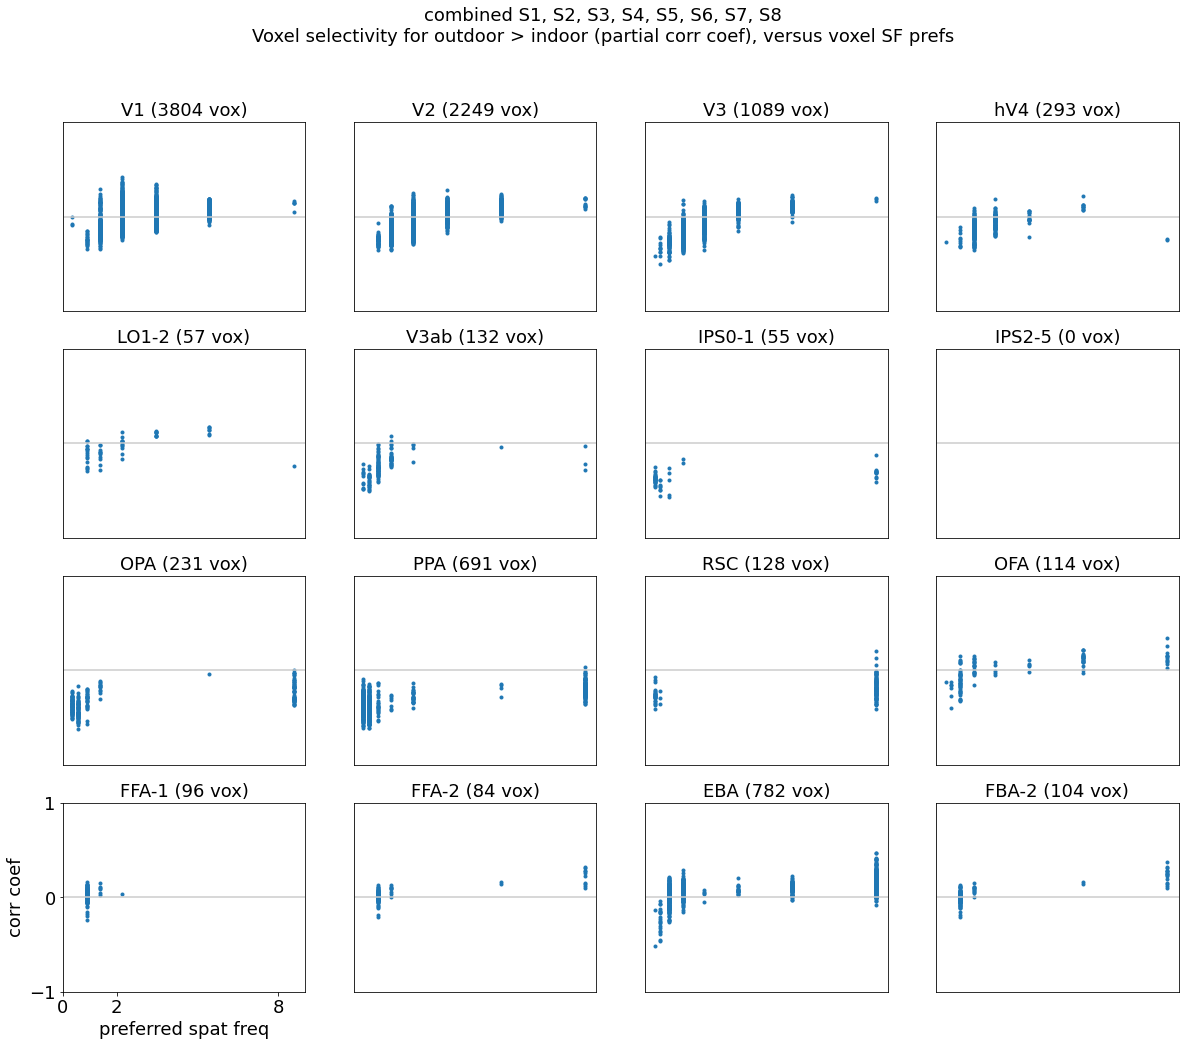

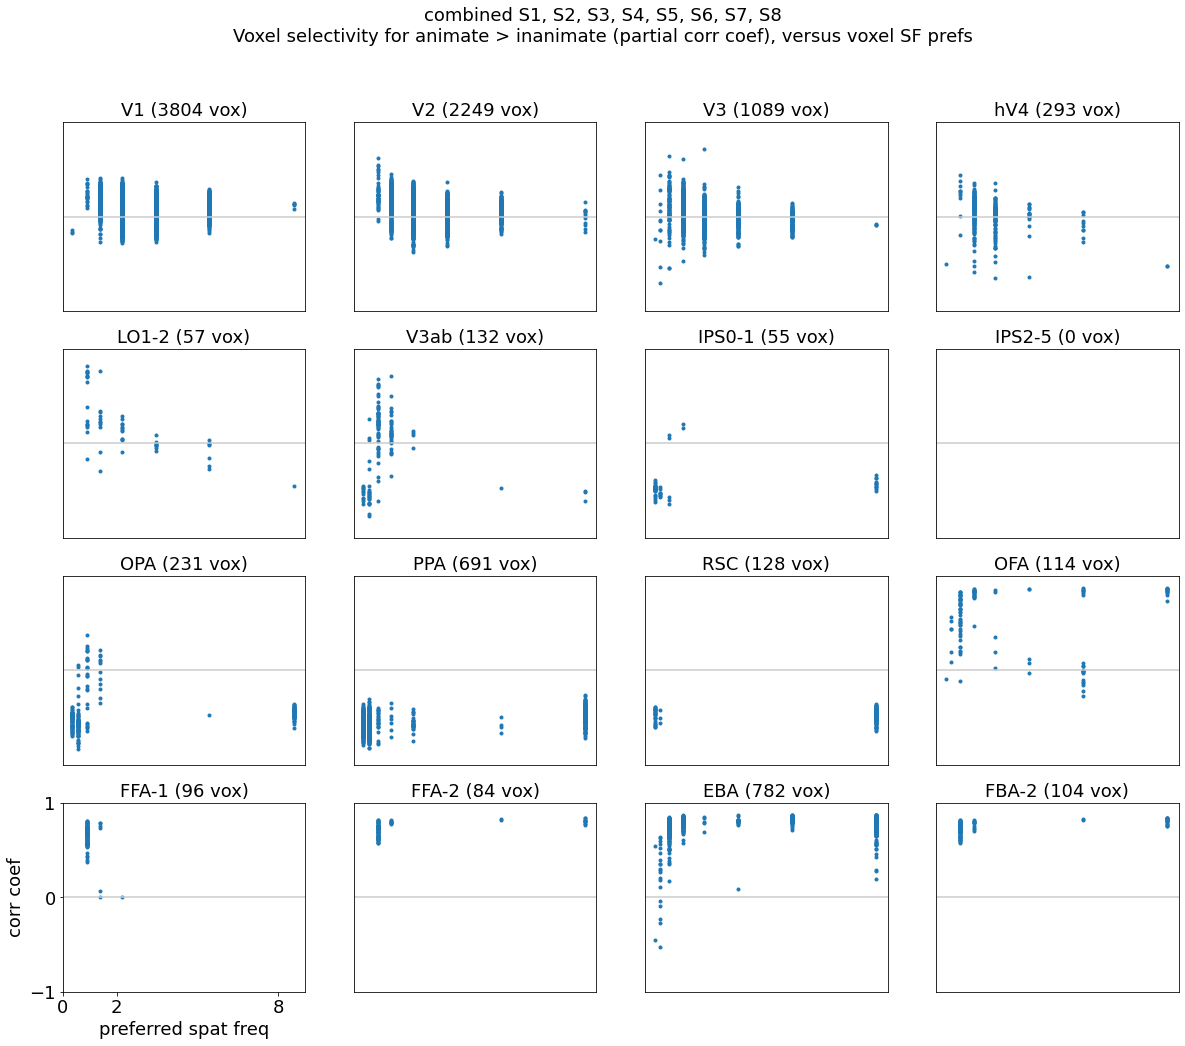

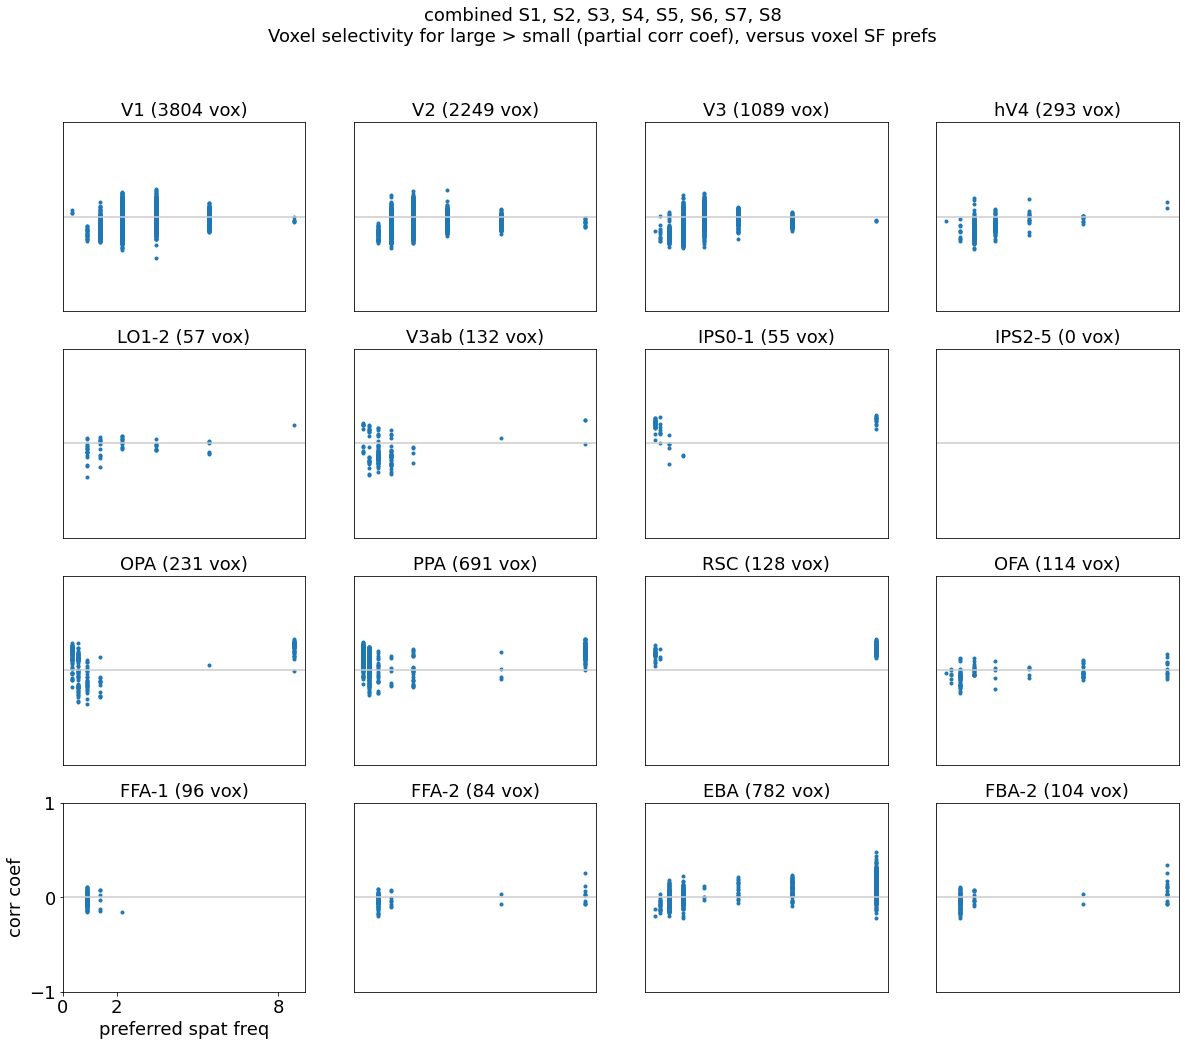

In [13]:
import copy

plot_utils.set_all_font_sizes(fs = 18)

dd2plot = [0,1,2];

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
inds2use = val_r2 > r2_cutoff

which_negate = [1]


for dd in dd2plot:
    
    val1 = sf_unique[preferred_sf_corr.astype(int)]
    val2 = copy.deepcopy(c_partial[:,dd])
        
    if dd in which_negate:
        name = '%s > %s'%(level_names[dd][0].split('has_')[1], level_names[dd][1].split('has_')[1])
        val2 = (-1)*val2
    else:
        name = '%s > %s'%(level_names[dd][1].split('has_')[1], level_names[dd][0].split('has_')[1])   

    
    dat = np.concatenate((val1[:,np.newaxis],val2[:,np.newaxis]), axis=1)

    sp = plot_utils.scatter_plot(color=None, xlabel='preferred spat freq', \
                                 ylabel='corr coef', \
                                 xlims=[0,9], ylims=[-1,1], \
                      xticks=[0,2,8], yticks=([-1,0,1]),\
                      show_diagonal=False, show_axes=True, square=False);

    title = '%s\nVoxel selectivity for %s (partial corr coef), versus voxel SF prefs'\
                                   %(summary_plots.get_substr(out), name)
    plot_utils.create_roi_subplots(dat, inds2use, sp, roi_def=roi_def,\
                        suptitle=title, \
                       label_just_corner=True, figsize=(20,16))


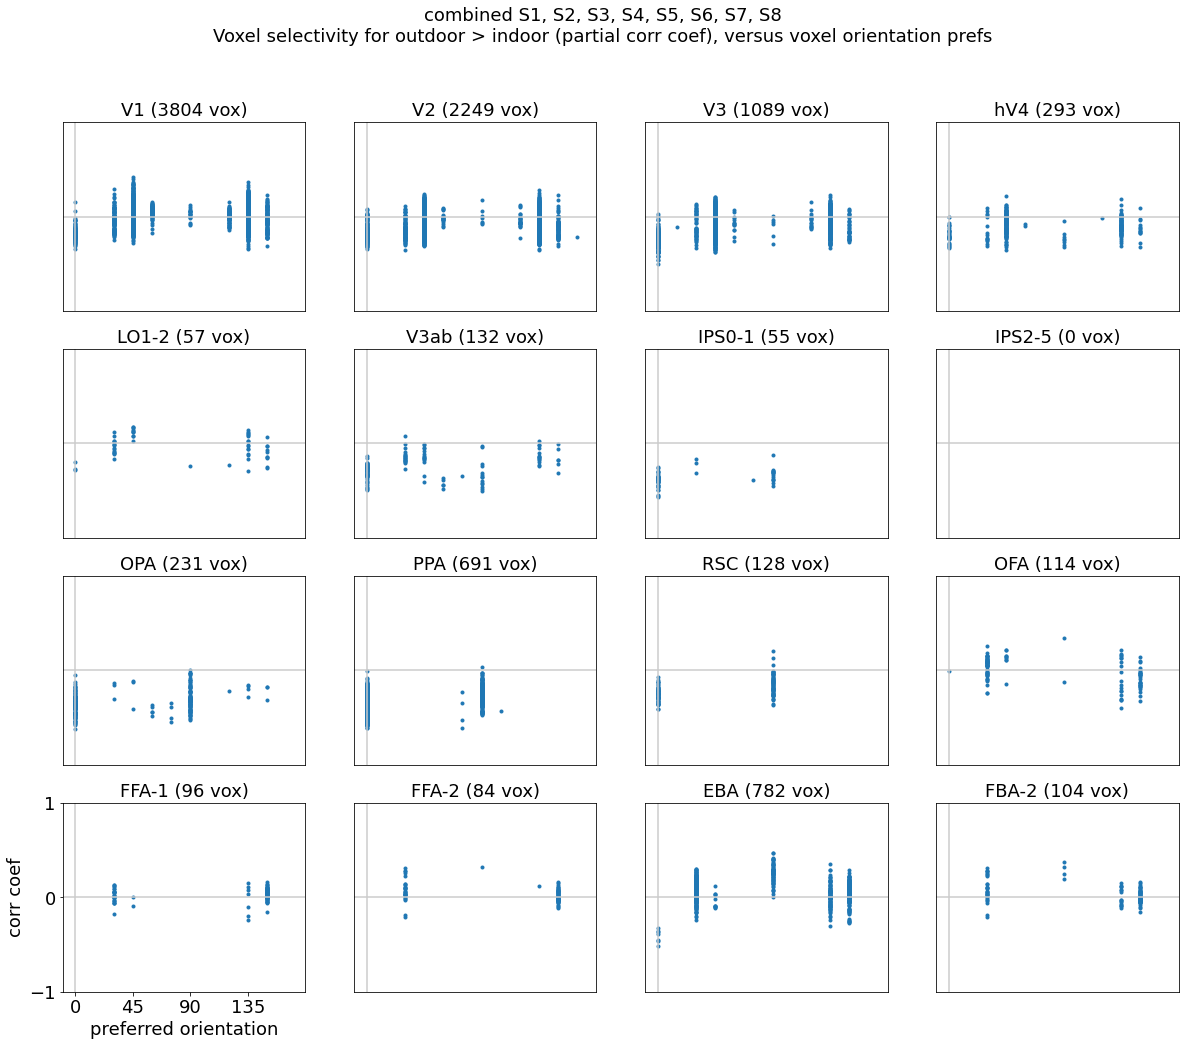

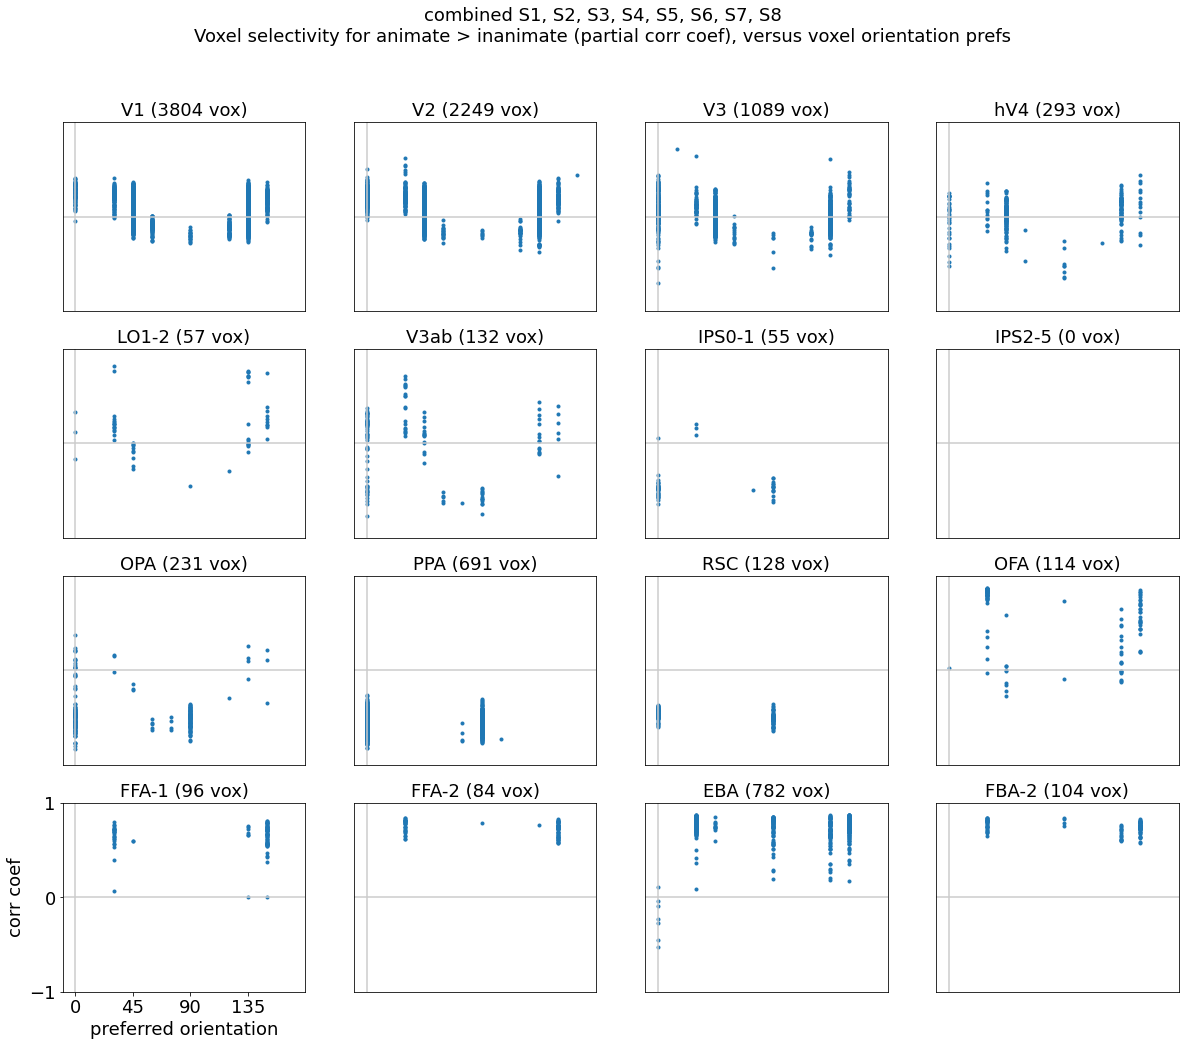

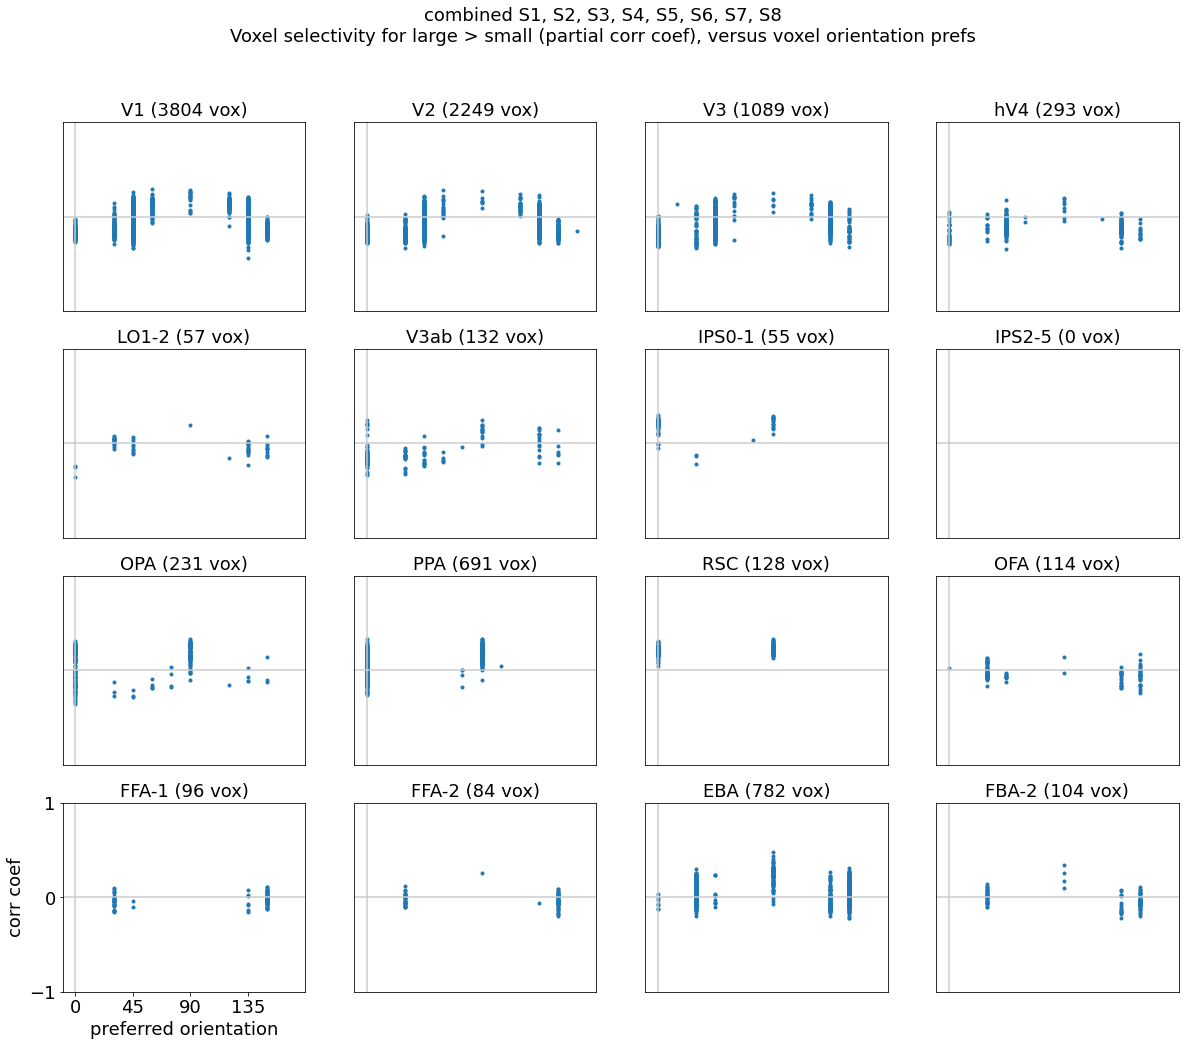

In [14]:
import copy

plot_utils.set_all_font_sizes(fs = 18)

dd2plot = [0,1,2];

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
inds2use = val_r2 > r2_cutoff

which_negate = [1]

for dd in dd2plot:
    
    val1 = ori_unique[preferred_ori_corr.astype(int)]
    val2 = copy.deepcopy(c_partial[:,dd])
        
    if dd in which_negate:
        name = '%s > %s'%(level_names[dd][0].split('has_')[1], level_names[dd][1].split('has_')[1])
        val2 = (-1)*val2
    else:
        name = '%s > %s'%(level_names[dd][1].split('has_')[1], level_names[dd][0].split('has_')[1])   

    
    dat = np.concatenate((val1[:,np.newaxis],val2[:,np.newaxis]), axis=1)

#     ptcolor=np.array([[0.6, 0.6, 0.6, 0.2]])
    ptcolor=None
    sp = plot_utils.scatter_plot(color=ptcolor, xlabel='preferred orientation', \
                                 ylabel='corr coef', \
                                 xlims=[-10,180], ylims=[-1,1], \
                      xticks=[0,45,90,135], yticks=([-1,0,1]),\
                      show_diagonal=False, show_axes=True, square=False);

    title = '%s\nVoxel selectivity for %s (partial corr coef), versus voxel orientation prefs'\
                                   %(summary_plots.get_substr(out), name)
    plot_utils.create_roi_subplots(dat, inds2use, sp, roi_def=roi_def,\
                        suptitle=title, \
                       label_just_corner=True, figsize=(20,16))
